In [8]:
!pip install --upgrade ultralytics --no-deps

from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, random, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import yaml
from IPython.display import Image, display
import glob

In [9]:
# 3. Define Dataset Paths
# =====================================================
dataset_path = "/kaggle/input/microscopy-cell-segmentation"
yaml_path = Path(f"{dataset_path}/data.yaml")

print("📂 Dataset path:", dataset_path)
print("📄 YAML path:", yaml_path)


📂 Dataset path: /kaggle/input/microscopy-cell-segmentation
📄 YAML path: /kaggle/input/microscopy-cell-segmentation/data.yaml


In [10]:
# 4. Validate and Fix data.yaml
# =====================================================
# Read YAML (if missing or broken, create a new one)
try:
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    if not isinstance(data, dict):
        raise ValueError("data.yaml is not a valid YAML dict.")
except Exception as e:
    print("⚠️ Could not read data.yaml, creating a new one from scratch.")
    data = {}

# Root of dataset
root = "/kaggle/input/microscopy-cell-segmentation"

# Function to fix/convert relative paths
def fix_path(p, default):
    if not p:
        return default
    if not p.startswith("/kaggle"):
        return str(Path(root) / p)
    return p

# Assign or fix required fields
data['train'] = fix_path(data.get('train'), f"{root}/train/images")
data['val']   = fix_path(data.get('val'), f"{root}/valid/images")
data['test']  = fix_path(data.get('test'), f"{root}/test/images")

# Class names (default to 1 class: 'cell')
if 'names' not in data or not data['names']:
    data['names'] = ['cell']
data['nc'] = len(data['names'])

# Save fixed YAML
fixed_yaml_path = Path("/kaggle/working/data_fixed.yaml")
with open(fixed_yaml_path, 'w') as f:
    yaml.dump(data, f, sort_keys=False)

print("✅ data.yaml validated and fixed →", fixed_yaml_path)
print(yaml.dump(data, sort_keys=False))


✅ data.yaml validated and fixed → /kaggle/working/data_fixed.yaml
train: /kaggle/input/microscopy-cell-segmentation/../train/images
val: /kaggle/input/microscopy-cell-segmentation/../valid/images
test: /kaggle/input/microscopy-cell-segmentation/../test/images
nc: 2
names:
- blood_vessel
- glomerulus
roboflow:
  workspace: studentdatasets
  project: microscopy-cell-segmentation
  version: 21
  license: MIT
  url: https://universe.roboflow.com/studentdatasets/microscopy-cell-segmentation/dataset/21



In [11]:
# 5. Inspect Dataset Structure
# =====================================================
print("\n📁 Dataset Structure:")
for root_dir, dirs, files in os.walk(dataset_path):
    level = root_dir.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root_dir)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:3]:  # Show only a few files
        print(f"{subindent}{f}")
print("✅ Folder structure looks good.\n")




📁 Dataset Structure:
microscopy-cell-segmentation/
  README.dataset.txt
  README.roboflow.txt
  data.yaml
  valid/
    labels/
      82c4fcba8d45_png.rf.b35509e1230026b20ad37a79df5009b8.txt
      e1610493df63_png.rf.f9d6c4c98e7e54423fdb2bca0b5bca07.txt
      2e02a3e00059_png.rf.5fd129f948e9f03e623a54105e5335c7.txt
    images/
      d16eb475a112_png.rf.b5037e376f0c0c5629a022c84670b7a6.jpg
      7b7327ccac8d_png.rf.b941fe48599388dca934db610f97bfb0.jpg
      3e794841f2da_png.rf.7f47dafcbd4baa56a8227ebbe8deb147.jpg
  test/
    labels/
      0e4c8b91d6e0_png.rf.fd5ec1898dc57d3612ec3a6627e4cbe8.txt
      add51d3c4a75_png.rf.d49103a1b8bef84e33abaaf9748d1f43.txt
      5b40a523ce88_png.rf.0463536f7b72ce83d485fda510a5f231.txt
    images/
      a9a0dd9d1728_png.rf.b975b6a4aa34bc69e0262f9a95c80470.jpg
      ecb5770df2fc_png.rf.3f365404aa1daf2ecbf789b2bcdf5e42.jpg
      d9706b0903b2_png.rf.3f61a3e4f8e4e3b15f37f0301b19c5be.jpg
  train/
    labels/
      a0c0e4d2953d_png.rf.c81f822e753ec73e874779084

In [13]:
# 6. Load YOLOv11 Segmentation Model
# =====================================================
# Available model sizes: yolo11n-seg.pt, yolo11s-seg.pt, yolo11m-seg.pt, yolo11l-seg.pt
model = YOLO("yolo11s-seg.pt")  # Pre-trained small segmentation model
print("✅ YOLOv11 model loaded successfully.")

✅ YOLOv11 model loaded successfully.


In [16]:
# =====================================================
# 💡 FIX: Ensure all dataset paths are absolute and exist
# =====================================================
from pathlib import Path

root = "/kaggle/input/microscopy-cell-segmentation"

fixed_data = {
    "train": f"{root}/train/images",
    "val": f"{root}/valid/images",
    "test": f"{root}/test/images",
    "nc": 1,
    "names": ["cell"]
}

# Check existence
for k, v in fixed_data.items():
    if k in ["train", "val", "test"]:
        if not Path(v).exists():
            raise FileNotFoundError(f"❌ Missing folder: {v}")
        else:
            print(f"✅ Found {k} folder:", v)

# Save clean, verified YAML
final_yaml_path = "/kaggle/working/data_verified.yaml"
with open(final_yaml_path, "w") as f:
    yaml.dump(fixed_data, f, sort_keys=False)

print(f"✅ Final verified YAML saved to {final_yaml_path}")
print(yaml.dump(fixed_data, sort_keys=False))


✅ Found train folder: /kaggle/input/microscopy-cell-segmentation/train/images
✅ Found val folder: /kaggle/input/microscopy-cell-segmentation/valid/images
✅ Found test folder: /kaggle/input/microscopy-cell-segmentation/test/images
✅ Final verified YAML saved to /kaggle/working/data_verified.yaml
train: /kaggle/input/microscopy-cell-segmentation/train/images
val: /kaggle/input/microscopy-cell-segmentation/valid/images
test: /kaggle/input/microscopy-cell-segmentation/test/images
nc: 1
names:
- cell



In [20]:
import os
import yaml
from pathlib import Path

# =====================================================
# 1️⃣ Define dataset root and expected structure
# =====================================================
root = "/kaggle/input/microscopy-cell-segmentation"

# Define expected folders
paths = {
    "train": f"{root}/train/images",
    "val": f"{root}/valid/images",
    "test": f"{root}/test/images",
}

# =====================================================
# 2️⃣ Verify folders actually exist
# =====================================================
for key, path in paths.items():
    if not Path(path).exists():
        raise FileNotFoundError(f"❌ Missing folder for {key}: {path}")
    else:
        print(f"✅ Found {key} folder: {path}")

# =====================================================
# 3️⃣ Create a clean YOLO data.yaml
# =====================================================
data_yaml = {
    "train": paths["train"],
    "val": paths["val"],
    "test": paths["test"],
    "nc": 1,              # Number of classes (adjust if more)
    "names": ["cell"]     # Class names
}

yaml_path = "/kaggle/working/data_verified.yaml"

with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("\n✅ Final YAML created at:", yaml_path)
print(yaml.dump(data_yaml, sort_keys=False))


✅ Found train folder: /kaggle/input/microscopy-cell-segmentation/train/images
✅ Found val folder: /kaggle/input/microscopy-cell-segmentation/valid/images
✅ Found test folder: /kaggle/input/microscopy-cell-segmentation/test/images

✅ Final YAML created at: /kaggle/working/data_verified.yaml
train: /kaggle/input/microscopy-cell-segmentation/train/images
val: /kaggle/input/microscopy-cell-segmentation/valid/images
test: /kaggle/input/microscopy-cell-segmentation/test/images
nc: 1
names:
- cell



In [21]:
# 7. Train the Model
# =====================================================
from ultralytics import YOLO

# Load YOLOv11 segmentation model (you can change to yolo11m-seg.pt, etc.)
model = YOLO("yolo11s-seg.pt")

# Train
results = model.train(
    data="/kaggle/working/data_verified.yaml",
    epochs=5,
    imgsz=640,
    batch=8,
    project="/kaggle/working",
    name="yolo11-cell-seg",
    device=0,
    verbose=True
)


Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_verified.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11-cell-seg6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1037       6620      0.621      0.584      0.617      0.321      0.633      0.581      0.625      0.282
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /kaggle/working/yolo11-cell-seg6


Step 1: Find the Correct Folder

Run this cell first to check where YOLO actually stored your experiment results:

In [23]:
import os

for root, dirs, files in os.walk("/kaggle/working", topdown=True):
    for name in files:
        if name == "results.csv":
            print("Found results.csv at:", os.path.join(root, name))


Found results.csv at: /kaggle/working/yolo11-cell-seg6/results.csv


In [25]:
csv_path = "/kaggle/working/yolo11-cell-seg6/results.csv"  # <-- replace this with your printed path


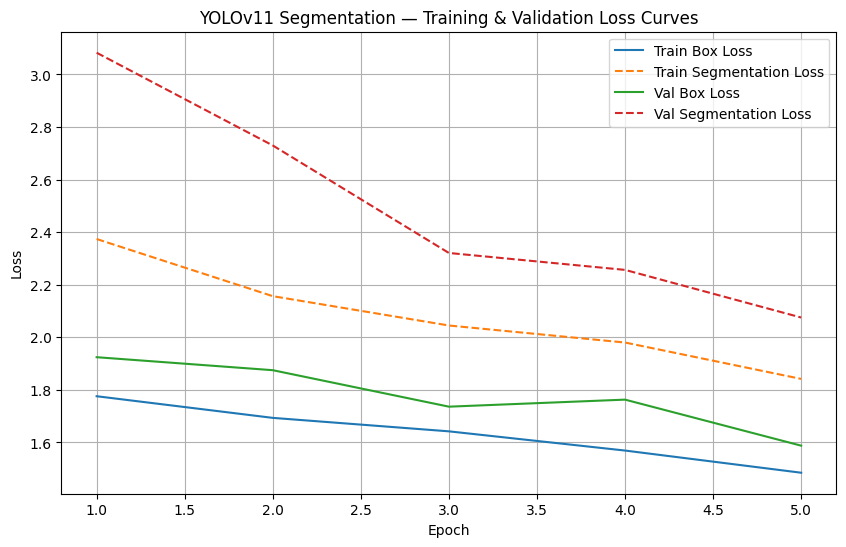

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Correct syntax: parentheses around the path
df = pd.read_csv("/kaggle/working/yolo11-cell-seg6/results.csv")

plt.figure(figsize=(10, 6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/seg_loss"], label="Train Segmentation Loss", linestyle="--")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/seg_loss"], label="Val Segmentation Loss", linestyle="--")

plt.title("YOLOv11 Segmentation — Training & Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Training results saved to: /kaggle/working/yolo11-cell-seg6

Training/Validation Loss Curves:


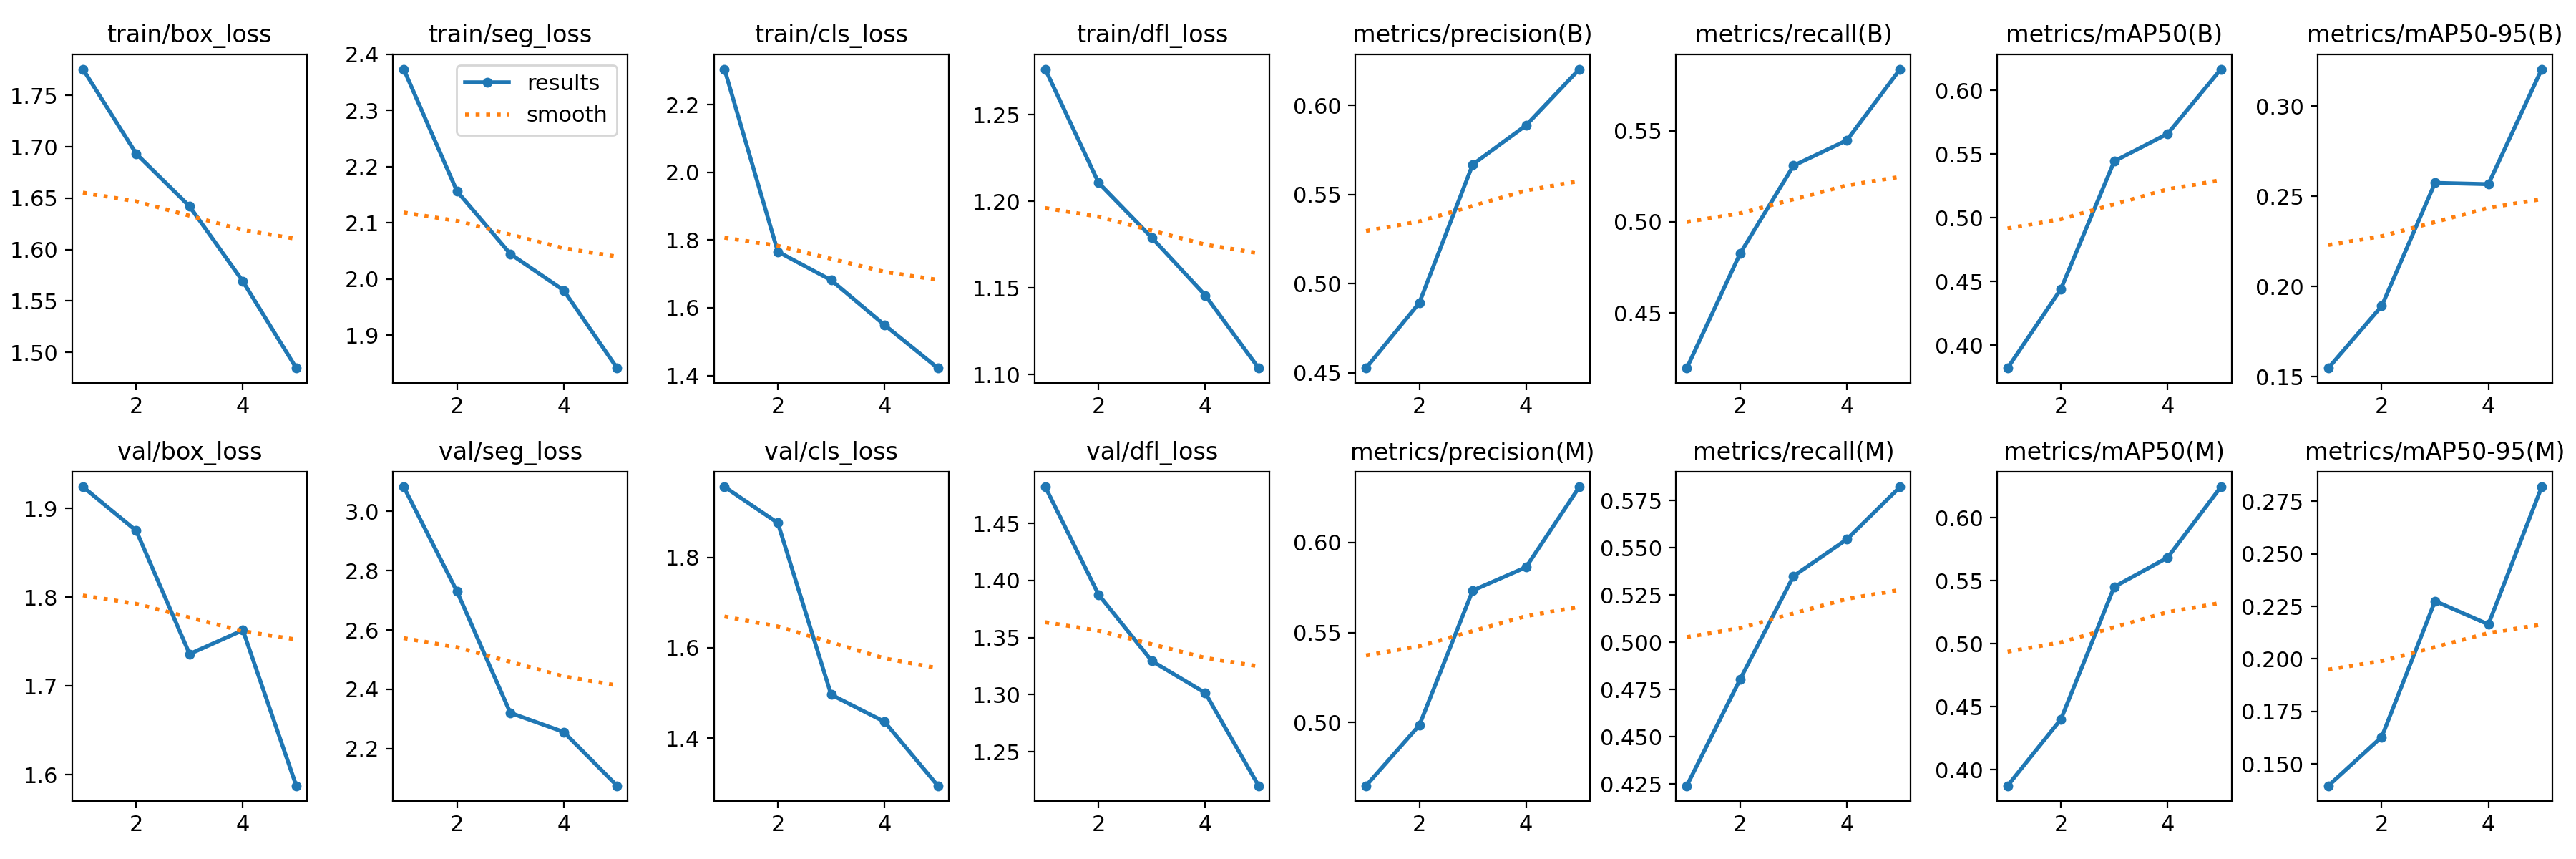


Validation Metrics (Confusion Matrix):


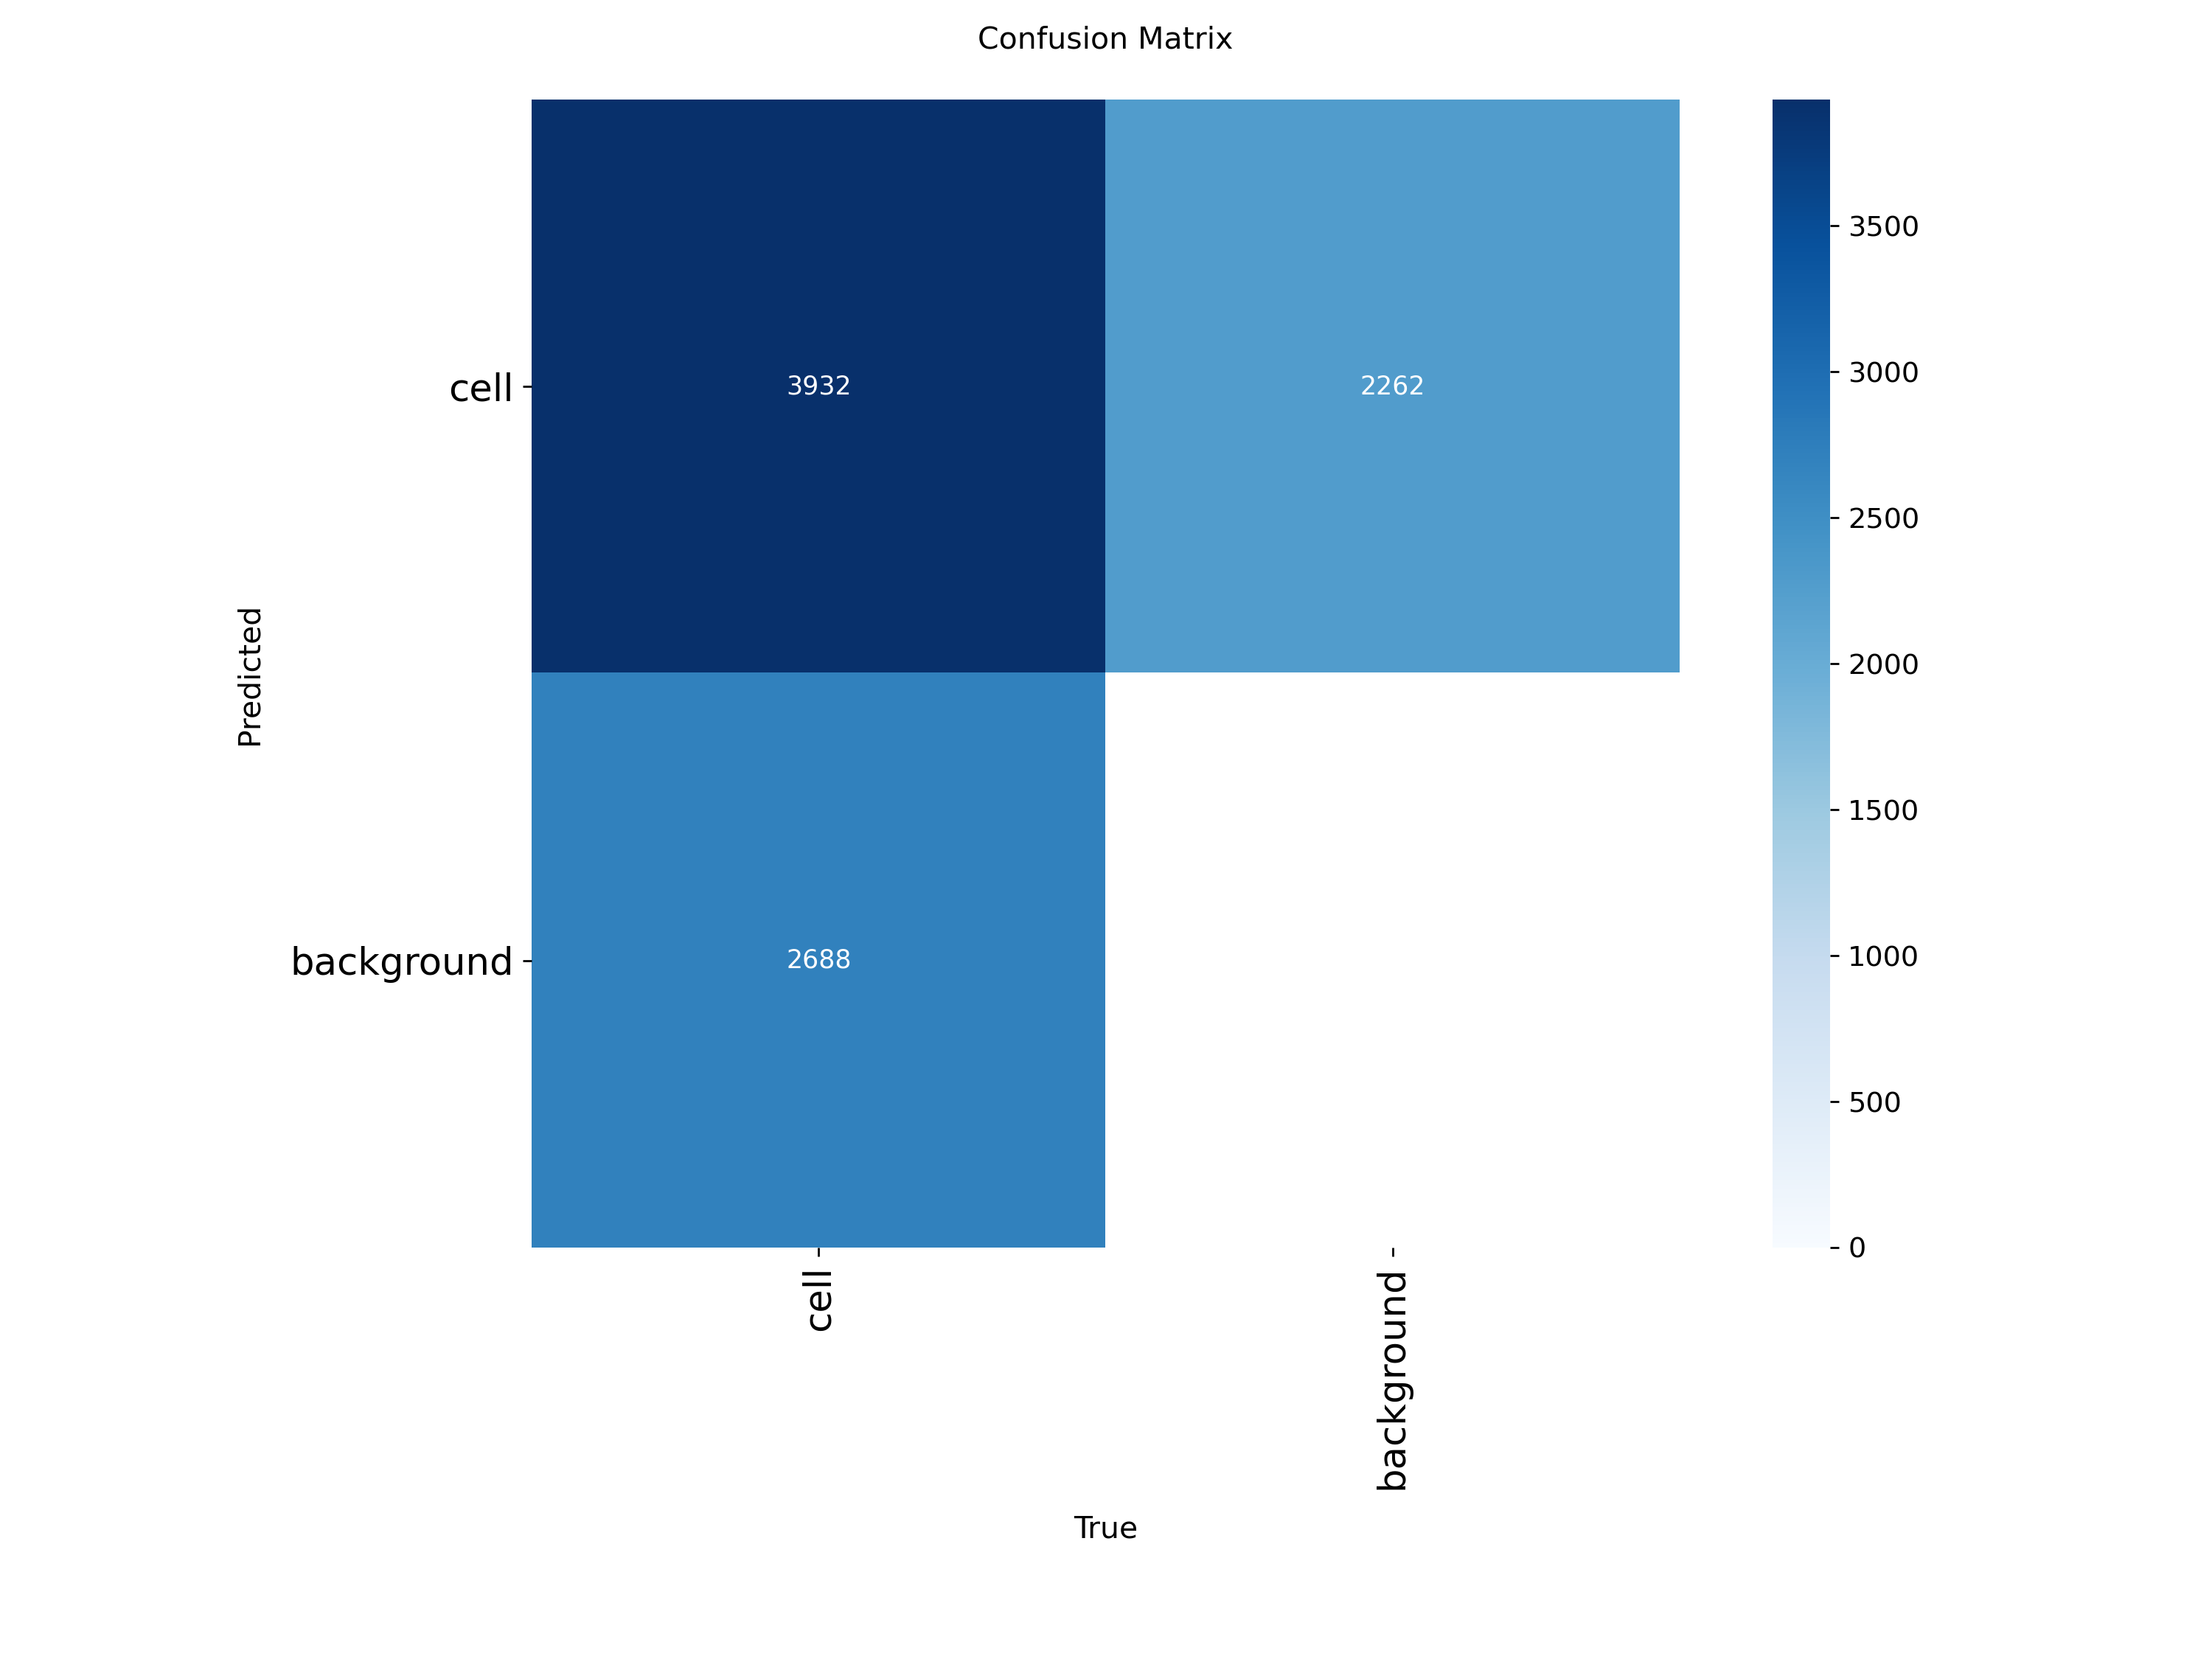

In [31]:
# The 'results' object contains the path to the run
run_dir = results.save_dir  # This gets the directory, e.g., 'Microscope-YOLO/run1'

print(f"Training results saved to: {run_dir}")

# Display the training and validation loss curves
# These are required by the assignment PDF 
print("\nTraining/Validation Loss Curves:")
display(Image(filename=f"{run_dir}/results.png", width=800))

# Display the validation metrics (mAP@0.5, etc.)
# This shows the mAP@0.5 or IoU scores 
print("\nValidation Metrics (Confusion Matrix):")
display(Image(filename=f"{run_dir}/confusion_matrix.png", width=600))

In [33]:
import os
from ultralytics import YOLO
from IPython.display import Image, display

# Define the run directory where the model was saved
run_dir = "/kaggle/working/yolo11-cell-seg6"  # Adjust if your training run name differs

# Load the best trained model
best_model = YOLO(f"{run_dir}/weights/best.pt")

# ✅ Correct test image directory path
TEST_IMAGE_DIR = "/kaggle/input/microscopy-cell-segmentation/test/images"

# Check if test directory exists
if not os.path.exists(TEST_IMAGE_DIR):
    raise FileNotFoundError(f"Test image folder not found at: {TEST_IMAGE_DIR}")

# Get some test images (limit to first 4)
test_images = [os.path.join(TEST_IMAGE_DIR, f) for f in os.listdir(TEST_IMAGE_DIR) if f.endswith(('.jpg', '.png'))][:4]

# Run predictions and save results
predict_results = best_model.predict(source=test_images, save=True, project=run_dir, name="predict")

# Display the prediction results
print("\n✅ Test Set Predictions:")
for i, img_path in enumerate(test_images):
    pred_path = f"{run_dir}/predict/image{i+1}.jpg"
    if os.path.exists(pred_path):
        print(f"Displaying prediction for: {os.path.basename(img_path)}")
        display(Image(filename=pred_path, width=600))
    else:
        print(f"Prediction done for {os.path.basename(img_path)} — check '{run_dir}/predict' folder.")



0: 640x640 8 cells, 17.7ms
1: 640x640 2 cells, 17.7ms
2: 640x640 1 cell, 17.7ms
3: 640x640 18 cells, 17.7ms
Speed: 2.6ms preprocess, 17.7ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/yolo11-cell-seg6/predict

✅ Test Set Predictions:
Prediction done for a9a0dd9d1728_png.rf.b975b6a4aa34bc69e0262f9a95c80470.jpg — check '/kaggle/working/yolo11-cell-seg6/predict' folder.
Prediction done for ecb5770df2fc_png.rf.3f365404aa1daf2ecbf789b2bcdf5e42.jpg — check '/kaggle/working/yolo11-cell-seg6/predict' folder.
Prediction done for d9706b0903b2_png.rf.3f61a3e4f8e4e3b15f37f0301b19c5be.jpg — check '/kaggle/working/yolo11-cell-seg6/predict' folder.
Prediction done for a6fca9aaa7a7_png.rf.0795607416c5b7a90bad30185fc0022a.jpg — check '/kaggle/working/yolo11-cell-seg6/predict' folder.
